In [1]:
using LinearAlgebra

function swann_method(f, x0, h=0.1)
    first = x0
    second = x0 + h
    # если функция растет, меняем направление движения
    if f(second) > f(first)
        h = -h
        first, second = second, second + h
    end
    last = second + h
    
    # увеличиваем шаг движения, если функция уменьшается
    while f(last) < f(second)
        h *= 2
        first, second, last = second, last, last + h
    end
    # перепрыгнули далеко
    if second > last
        first, second, last = last, second, first
    end

    return first, last
end

swann_method (generic function with 2 methods)

In [4]:
using LinearAlgebra
function df(f, x::Vector{Float64}, i, h=1e-5)
    x_plus = copy(x)
    x_minus = copy(x)
    
    x_plus[i] += h
    x_minus[i] -= h
    
    df_dx = (f(x_plus) - f(x_minus)) / (2h)
    
    return df_dx
end

function gradient(f, x::Vector{Float64})
    grad = []
    for i in 1:length(x)
        push!(grad, df(f, x, i))
    end
    return grad
end

gradient (generic function with 1 method)

In [2]:
using LinearAlgebra

function golden_section_search(f, a, b, eps=1e-5)
    phi = (sqrt(5) - 1) / 2 
    x1 = b - phi * (b - a)
    x2 = a + phi * (b - a)
    
    while abs(b - a) > eps
        if f(x1) <= f(x2)
            b = x2
        else
            a = x1
        end
        x1 = b - phi * (b - a)
        x2 = a + phi * (b - a)
    end
    
    return (a + b) / 2
end

golden_section_search (generic function with 2 methods)

### BFGS

BFGS:
 точка минимума: [0.9999996870967209, 0.9999992523068931]
 кол-во итераций = 12


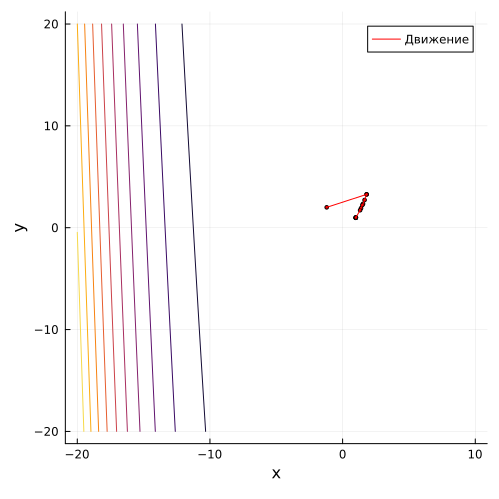

In [13]:
using Plots

max_iter = 100

d(x) = (1 - x[1])^2 + 100 * (x[2] - x[1]^2)^2
start = [-1.2, 2.0]
epsilon = 1e-4


function bfgs(f, start, epsilon)
    x = copy(start)
    points = [copy(x)]

    n = length(x)
    B = I(n)

    gradient = [df(f, x, j) for j in 1:n]
    i = 0

    while norm(gradient) > epsilon && i < max_iter
        s = -B * gradient

        g(alpha) = f(x + alpha * s)
        a, b = swann_method(g, 0.0)
        alpha = golden_section_search(g, a, b)

        x_new = x + alpha * s
        gradient_new = [df(f, x_new, j) for j in 1:n]

        y = gradient_new - gradient
        s = alpha * s

        rho = 1 / dot(y, s)
        B = (I - rho * s * y') * B * (I - rho * y * s') + rho * s * s'

        x = x_new
        gradient = gradient_new
        push!(points, copy(x))
        i += 1
    end
    return points, i
end


points, i = bfgs(d, start, epsilon)

x_min = points[end]
x = -20:0.1:10
y = -20:0.1:20
x_coords = [point[1] for point in points]
y_coords = [point[2] for point in points]
contour(x, y, (x, y) -> d([x, y]), levels = 10, xlabel="x", ylabel="y", colorbar=false, size=(500, 500))
scatter!(x_coords, y_coords, markersize=2, markershape=:circle, markercolor=:red, label = "")
p = plot!(x_coords, y_coords, label="Движение", line=:red)
println("BFGS:\n точка минимума: $x_min\n кол-во итераций = $i")
p

### L-BFGS

L-BFGS:
 точка минимума: [1.0000000782399192, 1.0000001488451917]
 кол-во итераций = 12


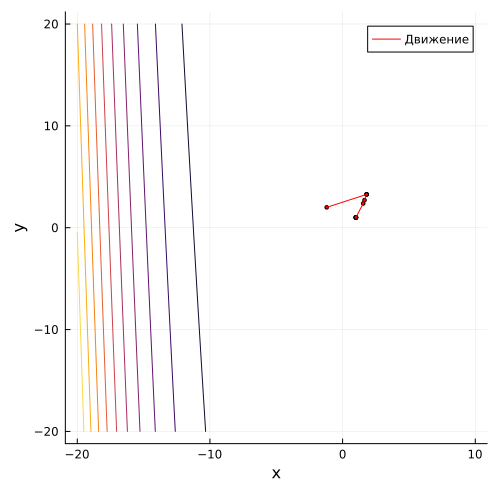

In [16]:
function approx_inv_hessian_lbfgs(s_hist, y_hist, rho_hist, gradient, m)
    q = copy(gradient)
    alpha = Vector{Float64}(undef, length(s_hist))
    beta = Vector{Float64}(undef, length(s_hist))

    for i in length(s_hist):-1:1
        alpha[i] = rho_hist[i] * dot(s_hist[i], q)
        q -= alpha[i] * y_hist[i]
    end

    z = m * q

    for i in 1:length(s_hist)
        beta[i] = rho_hist[i] * dot(y_hist[i], z)
        z += (alpha[i] - beta[i]) * s_hist[i]
    end

    return z
end

function lbfgs(f, start, epsilon, m=10)
    x = copy(start)
    points = [copy(x)]

    s_hist = []
    y_hist = []
    rho_hist = []

    gradient = [df(f, x, i) for i in 1:length(x)]

    i = 0
    while norm(gradient) > epsilon && i < max_iter
        s = -approx_inv_hessian_lbfgs(s_hist, y_hist, rho_hist, gradient, m)

        g(alpha) = f(x + alpha * s)
        a, b = swann_method(g, 0.0)
        alpha = golden_section_search(g, a, b)

        x_new = x + alpha * s
        gradient_new = [df(f, x_new, j) for j in 1:length(x)]

        y = gradient_new - gradient
        rho = 1 / dot(y, s)

        if length(s_hist) == m
            popfirst!(s_hist)
            popfirst!(y_hist)
            popfirst!(rho_hist)
        end

        push!(s_hist, s)
        push!(y_hist, y)
        push!(rho_hist, rho)

        x = x_new
        gradient = gradient_new

        push!(points, copy(x))
        i += 1
    end

    return points, i
end
points, i = lbfgs(d, start, epsilon)

x_min = points[end]
x = -20:0.1:10
y = -20:0.1:20
x_coords = [point[1] for point in points]
y_coords = [point[2] for point in points]
contour(x, y, (x, y) -> d([x, y]), levels = 10, xlabel="x", ylabel="y", colorbar=false, size=(500, 500))
scatter!(x_coords, y_coords, markersize=2, markershape=:circle, markercolor=:red, label = "")
p = plot!(x_coords, y_coords, label="Движение", line=:red)
println("L-BFGS:\n точка минимума: $x_min\n кол-во итераций = $i")
p